# Kernel Zoo -- Gaussian Process Priors
Mark van der Wilk, Spring 2021, Probabilistic Inference, Imperial College London

There are many different kernels that can be used as Gaussian process
covariance functions, giving priors on functions with wildly different
properties. We visualise a few here.

For more information, check out
- Rasmussen & Williams §4.2
- [Hyperparameter guide](https://infallible-thompson-49de36.netlify.app/)
- [GP Visualisation](http://www.it.uu.se/edu/course/homepage/apml/GP/)

Another nice interactive visualisation can be found at .

In most cases $x \in \mathbb R^D$, but we plot for $x \in \mathbb R$.

Try varying some of the parameters!


In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import gpflow
from tools import datasets
from tools import plotting
from tools.misc import sample_prior

save_figures_location = "/Users/markvdw/Documents/teaching/probabilistic-inference/2021/slides/figures/model_selection/"
savefig = lambda fig, fn: fig.savefig(f"{save_figures_location}{fn}") if savefig is not None else None

pX = np.linspace(-2, 8, 500)[:, None]

X = np.array([0.5, 2.3, 5.5])[:, None]
Y = np.array([-1.3, 0.4, 0.6])[:, None]

def plot_prior_posterior(m, plot_samples_z=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9.6, 2.8))
    samples = sample_prior(m.kernel, pX, num_samples=10 if plot_samples_z is None else plot_samples_z.shape[1])
    ax1.plot(pX, samples, color='C0', alpha=0.3)
    ax1.set_ylim(-3, 3)
    ax1.set_title("prior samples")

    m = gpflow.models.GPR((X, Y), m.kernel)
    m.likelihood.variance.assign(1e-5)
    plotting.plot_1d_model(m, plot_samples=True, plot_mean=True, plot_var='f', ax=ax2, pX=pX, plot_samples_z=plot_samples_z)
    ax2.plot(X, Y, 'o', color='C1')
    ax2.set_ylim(-3, 3)
    ax2.set_title("posterior samples")
    ax2.legend()
    return ax1, ax2



## Squared Exponential
$k(x, x') = \sigma_f^2\exp\left(-\frac{||x - x'||^2}{2\ell^2}\right)$

Parameters:
- $\sigma_f^2$: Marginal variance. Determines the amplitude of the wiggles.
- $\ell$: Lenghtscale. Determines how quickly the output varies w.r.t. the input.

### Varing the lengthscale

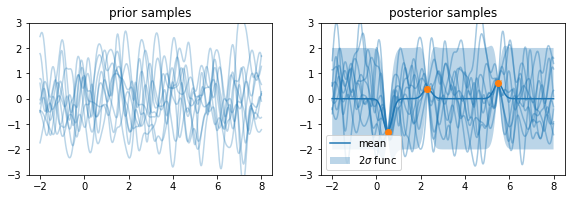

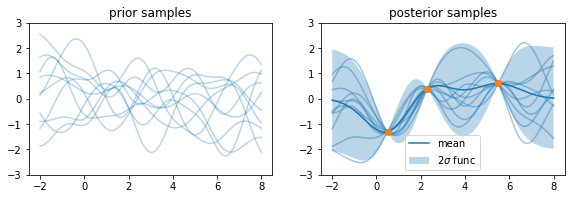

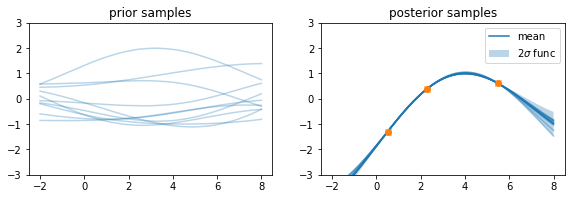

In [2]:
for l in [0.2, 1.0, 5.0]:
    kern = gpflow.kernels.SquaredExponential()
    kern.lengthscales.assign(l)
    m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
    plot_prior_posterior(m)

### Varying the marginal variance

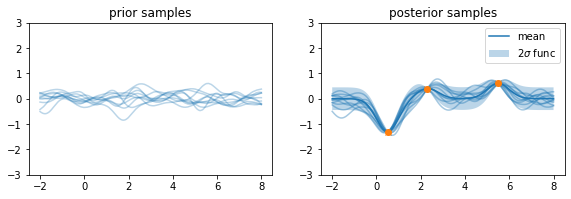

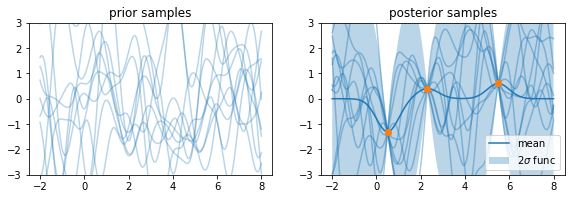

In [3]:
for s in [0.05, 4.0]:
    kern = gpflow.kernels.SquaredExponential()
    kern.lengthscales.assign(0.5)
    kern.variance.assign(s)
    m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
    plot_prior_posterior(m)



## Matèrn-1/2
Matèrn-1/2 kernels produce *non-differentiable* functions. Uncertainty
increases quicker when moving away from data points.

$k(x, x') = \sigma_f^2 \exp\left(-||x - x'||/\ell\right)$

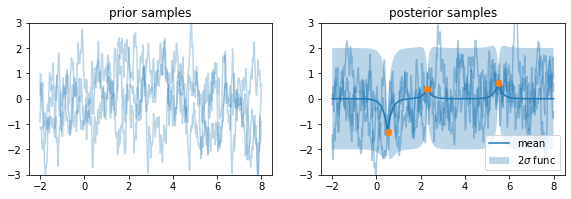

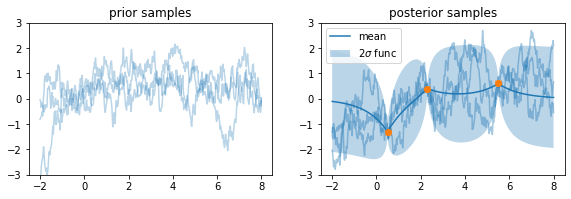

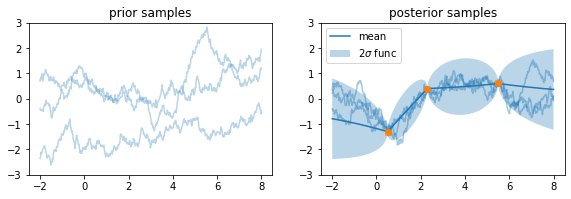

In [4]:
for l in [0.2, 1.0, 5.0]:
    kern = gpflow.kernels.Matern12()
    kern.lengthscales.assign(l)
    m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
    pz = np.random.randn(len(pX), 3)
    plot_prior_posterior(m, plot_samples_z=pz)



## Matèrn-3/2
Matèrn-3/2 kernels produce *once-differentiable* functions. Smoother than
Matèrn-1/2.

$k(x, x') = \sigma_f^2 (1 + \sqrt{3}||x-x'||) \exp\left(-\sqrt{3} ||x-x'||\right)$

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8bdb7a160>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8bdd26700>)

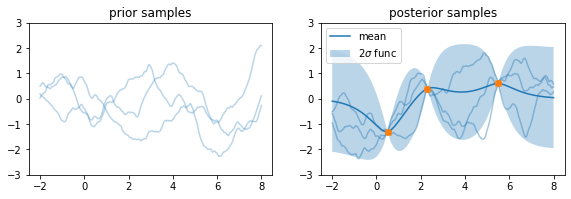

In [5]:
kern = gpflow.kernels.Matern32()
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 3)
plot_prior_posterior(m, plot_samples_z=pz)

## Periodic
Only produces periodic functions by mapping $d = \sin\left(\pi \frac{x - x'}{p}\right)$,
and then passing $d$ to a kernel that only depends on the Euclidean distance
(all of the above).

Parameters:
- $p$: Period of the periodic function.
- All other parameters from the "base kernel".

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8bddba4c0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8be9f30a0>)

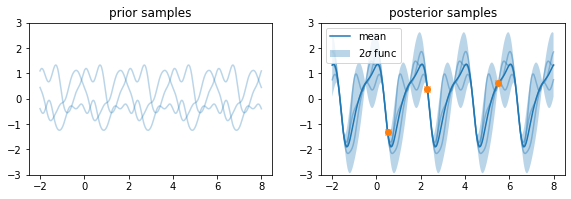

In [6]:
kern = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
kern.period.assign(2.0)
kern.base_kernel.lengthscales.assign(0.5)
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 3)
plot_prior_posterior(m, plot_samples_z=pz)


## Arc-Cosine kernel
This kernel is *non-stationary*, which means that it does not only depend on
the Euclidean distance between the two input points. Can be obtained from
taking an infintiely wide limit of a NN.

(-6.0, 6.0)

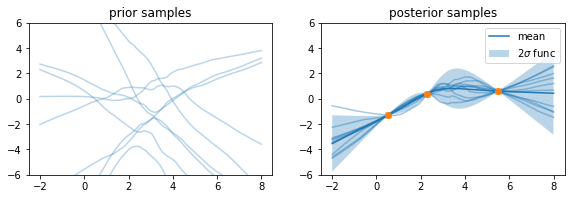

In [7]:
class ShiftedArcCosine(gpflow.kernels.ArcCosine):
    def K(self, X, X2=None):
        return super().K(X - 3.0, X2 - 3.0 if X2 is not None else X2)

    def K_diag(self, X):
        return super().K_diag(X - 3.0)

kern = ShiftedArcCosine(order=1, weight_variances=4.0, bias_variance=5.0)
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 10)
ax1, ax2 = plot_prior_posterior(m, plot_samples_z=pz)
ax1.set_ylim(-6, 6)
ax2.set_ylim(-6, 6)

## Polynomial kernels
Give polynomial functions as samples.


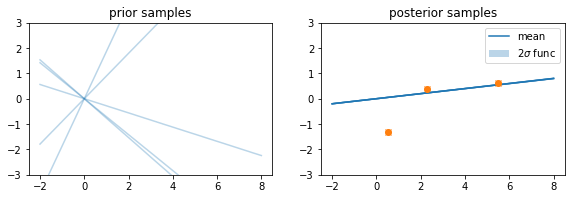

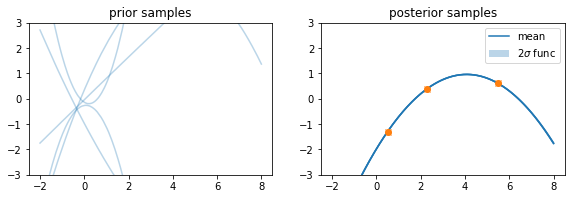

In [8]:
for kern in [gpflow.kernels.Linear(), gpflow.kernels.Polynomial(2.0)]:
    m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
    pz = np.random.randn(len(pX), 5)
    plot_prior_posterior(m, plot_samples_z=pz)


## Sums of Kernels
Summing two kernels gives you the sum of two GPs (prove this). This is useful,
as it allows us to combine earlier kernels to create new ones.

For example, we can get a linear trend plus some eviations

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8bd557e50>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8bd12a3d0>)

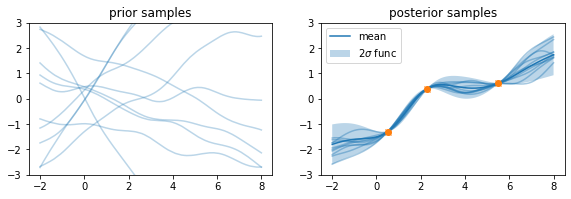

In [9]:
sqexp = gpflow.kernels.SquaredExponential()
sqexp.variance.assign(0.05)
kern = gpflow.kernels.Constant() + gpflow.kernels.Linear() + sqexp
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 10)
plot_prior_posterior(m, plot_samples_z=pz)



## Products of kernels
Multiplying kernels gives you a correlation between function values that is
only high, if both base kernels are high.

### Linear $\times$ SqExp
You get growing deviations! You can see this, since the marginal variance keeps growing:

$k(x, y) = \underbrace{xy}_{\text{keeps growing!}} \cdot k_{\text{sqexp}}(x, y)$


(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8bd59e8b0>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8bd3c70a0>)

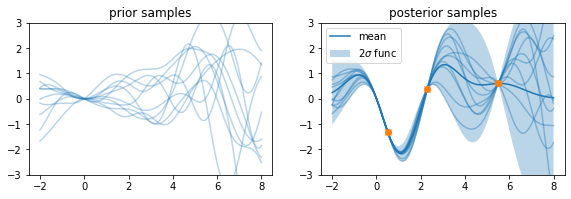

In [10]:
sqexp = gpflow.kernels.SquaredExponential()
linear = gpflow.kernels.Linear()
linear.variance = 0.1
kern = linear * sqexp
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 10)
plot_prior_posterior(m, plot_samples_z=pz)


### SqExp $\times$ Periodic
Period can change over time, since the SqExp decays in covariance!

(<matplotlib.axes._subplots.AxesSubplot at 0x7fb8dbef6e20>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb8dbe56340>)

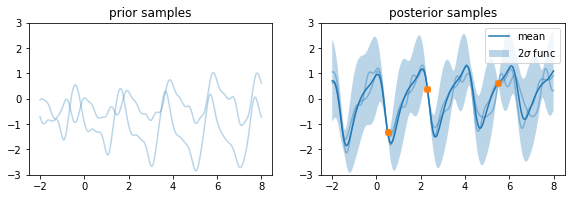

In [12]:
kern = gpflow.kernels.Periodic(base_kernel=gpflow.kernels.SquaredExponential())
kern.period.assign(2.0)
kern.base_kernel.lengthscales.assign(0.5)
sqexp.lengthscales.assign(7.0)
kern = kern * sqexp
m = gpflow.models.GPR((X, Y), kern); m.likelihood.variance.assign(1e-5)
pz = np.random.randn(len(pX), 2)
plot_prior_posterior(m, plot_samples_z=pz)